# Classification experiment of single (cutted) cells - HEAEL version

In [1]:
%reload_ext autoreload
%autoreload 2
from fastai import *
from fastai.vision import *
path = Path('./')

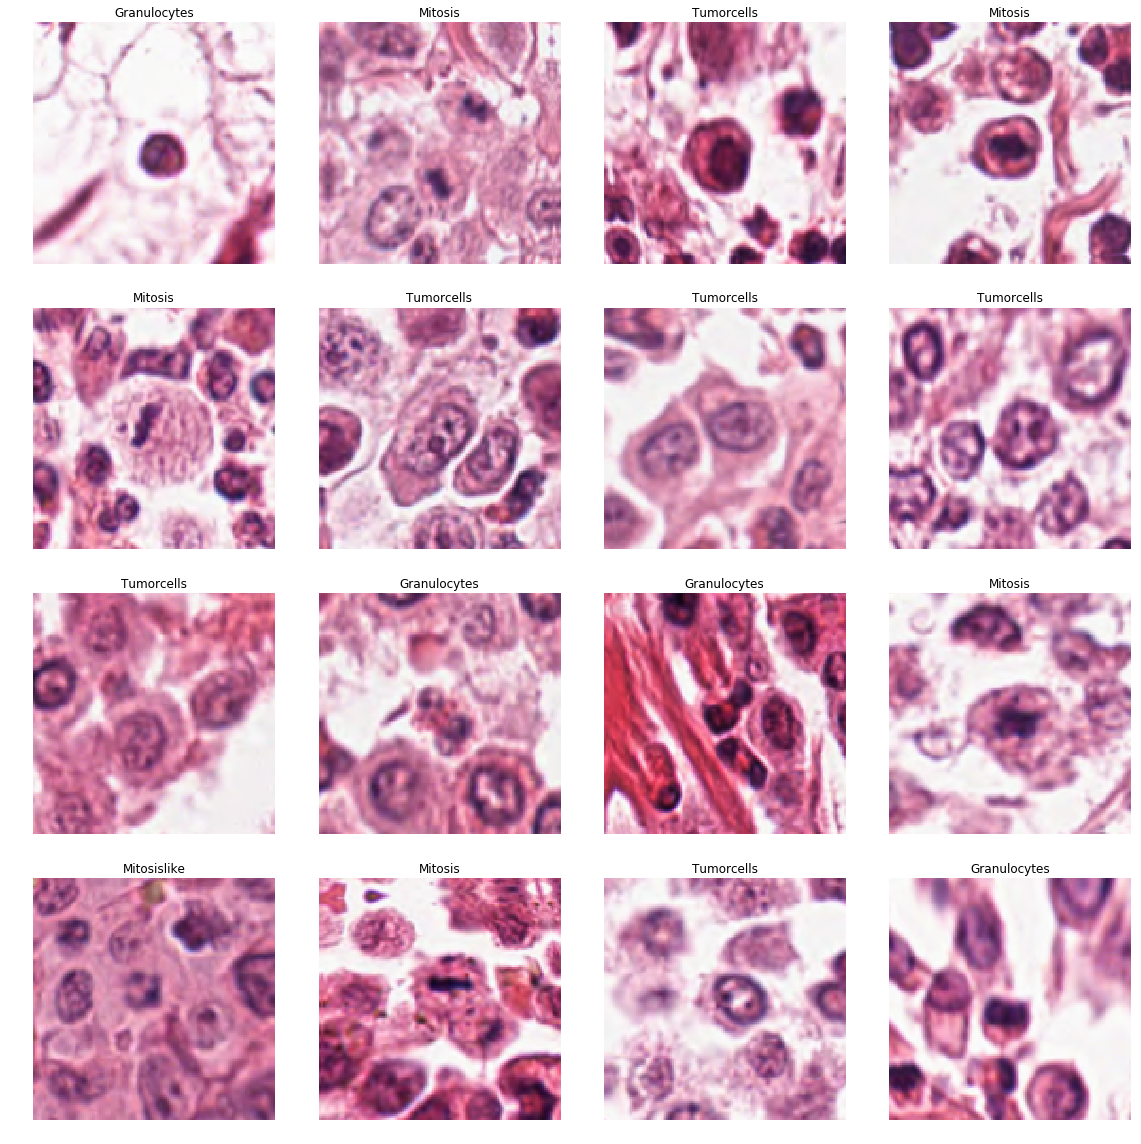

In [2]:
bs=16
data = ImageDataBunch.from_folder(Path('./DataHEAEL'),
        ds_tfms=get_transforms(), valid_pct=0.2, size=128, train='train', num_workers=4, bs=bs, test="test").normalize()

data.show_batch(rows=4)

In [3]:
data_test = (ImageList.from_folder(Path('./DataHEAEL/'))
        .split_by_folder(train='train', valid='test')
        .label_from_folder()).databunch().normalize()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


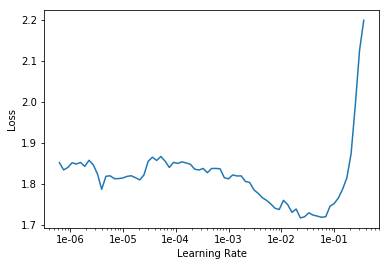

In [4]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy, callback_fns=[ShowGraph])
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.193995,0.147070,0.949660,03:27


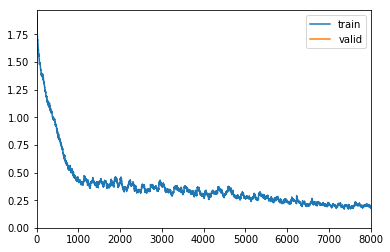

In [5]:
learn.fit_one_cycle(1,1e-2)

Unfreeze backbone of model, train for 10 epochs using cyclic learning rate scheme

epoch,train_loss,valid_loss,accuracy,time
0,0.254450,0.174231,0.948912,03:56
1,0.220497,0.154374,0.949068,06:19
2,0.196291,0.130752,0.955894,07:04
3,0.186537,0.235704,0.942585,06:26
4,0.146967,0.114316,0.956798,05:02
5,0.142420,0.130931,0.942491,04:44
6,0.111157,0.106282,0.958980,04:44
7,0.103929,0.100396,0.960663,04:44
8,0.108050,0.100265,0.960601,04:45
9,0.110404,0.096907,0.962128,04:48


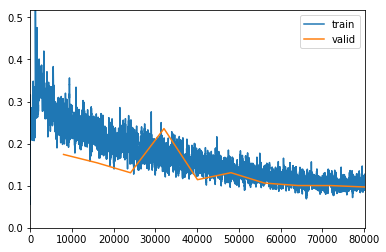

In [6]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3,1e-2), pct_start=0.05)


In [7]:
learn.data = data_test
interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Valid)
losses,idxs = interp.top_losses()


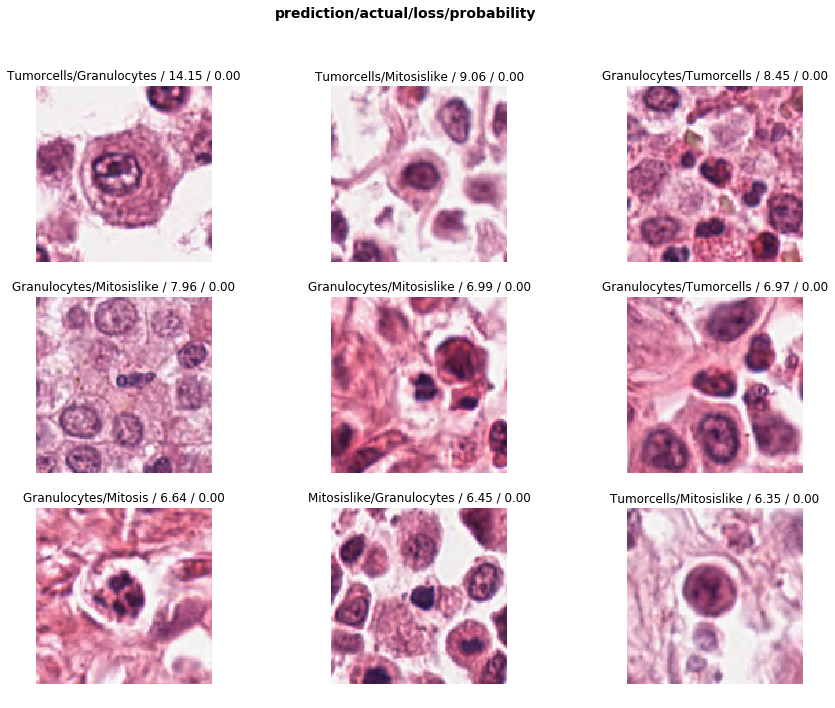

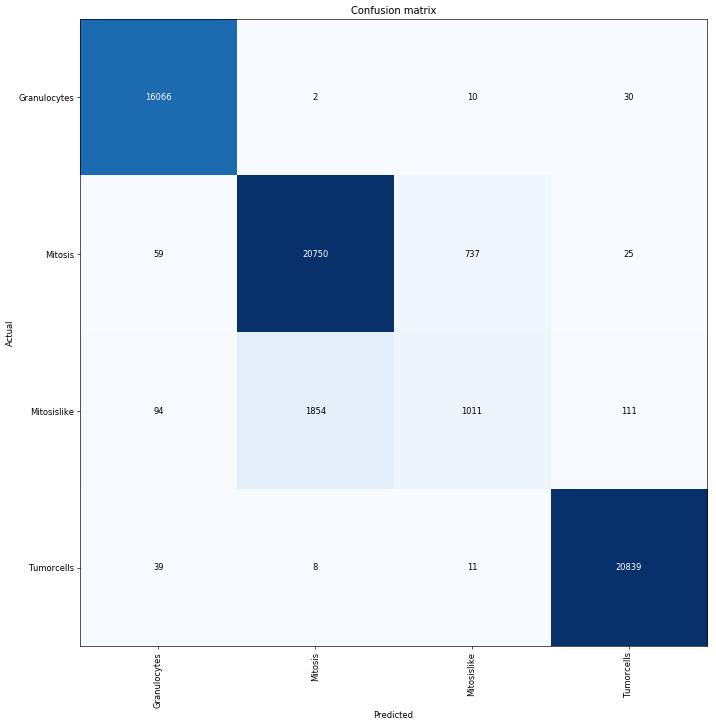

In [8]:
len(data.test_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


## Print confusion matrix, LaTeX style

In [9]:

print(" \\\\\n".join([" & ".join(map(str,line)) for line in interp.confusion_matrix()]))

16066 & 2 & 10 & 30 \\
59 & 20750 & 737 & 25 \\
94 & 1854 & 1011 & 111 \\
39 & 8 & 11 & 20839


## Find out test accuracy

In [10]:
c = interp.confusion_matrix()
accuracy = np.sum(c*np.eye(4))/np.sum(c)
print('Test accuracy: ',accuracy)

Test accuracy:  0.9516594750673198


In [11]:
learn.save('CellClassifier_128px_HEAEL.pth')
learn.export('CellClassifier_128px_HEAEL.pth')